# Self Organized Maps (SOMs)

Define the directory were all the files are saved.

In [1]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

# Nans
import missingno

# Kolmorgorov-Smirnov
from scipy.stats import kstest

## PCA Whitening and ZPCA Whitening

[Link to Explanation](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/)

[Link to Visualization](https://setosa.io/ev/principal-component-analysis/)

In [3]:
def pca_whitening(data, epsilon=1e-5):
    '''
    PCA whitening

    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data pca whitened
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

  
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    xPCAwhite = (whitening_matrix @ data_centered.T).T

    return xPCAwhite


def zca_whitening(data, epsilon=1e-5):
    '''
    ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data zca whitened

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_mean0 = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate x_rot and x_tilde
    x_rot = np.dot(data_mean0, eigvecs)

    # Whitening matrix: U * D^{-1/2} * U.T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply whitening
    xZCAwhite = data_mean0 @ whitening_matrix
    
    return xZCAwhite

In [4]:
def inverse_pca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse PCA whitening

    Args:
        original_data: original data
        whitened_data: whitened data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_centered = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    D_sqrt = np.diag(np.sqrt(eigvals + epsilon))

    
    # Calculate the inverse of the PCA whitening matrix
    X_centered = whitened_data @ ((eigvecs @ D_sqrt @ eigvecs.T))
    
    x_dewhitened = X_centered + data_mean.values

    return x_dewhitened


def inverse_zca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_mean0 = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate the inverse of the ZCA whitening matrix
    D = np.diag(np.sqrt(eigvals + epsilon))
    inverse_zca_matrix = eigvecs @ D @ eigvecs.T

    # Apply inverse transform and add mean back
    x_orig = (inverse_zca_matrix @ whitened_data.T).T + data_mean.values

    return x_orig


## Run the SOM

Import the matched catalog from NWAY and convert it to a Pandas DataFrame.

In [5]:
# RADIUS (3''), EMU (1''), DESY6GOLD (0.1''), VIKINGDR5 (0.1''), CATWISE2020 (0.2''), No MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.83
matched_no_mags_path = directory + 'cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag.fits'
matched_no_mags = Table.read(matched_no_mags_path)
matched_no_mags = matched_no_mags.to_pandas()

Filter using NWAY recomendations

In [6]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_no_mags['match_flag'] == 1) & (matched_no_mags['p_i'] >= 0.1) & (matched_no_mags['p_any'] >=0.83)
catalog_matches_noMags = matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

Number of objects in the catalog 11695


Select the objects that have matches in all the three surveys

In [7]:
# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99')
catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]
print(f'Number of objects in the catalog that have matches in all three surveys {len(catalog_matches_noMags_full)}')

Number of objects in the catalog that have matches in all three surveys 3855


In [8]:
catalog_filter = catalog_matches_noMags_full[~catalog_matches_noMags_full.isin([-999999488.0]).any(axis=1)]
catalog_filter = catalog_matches_noMags_full[catalog_matches_noMags_full['DESY6_mag_auto_g_extcorr'] < 40]

len(catalog_filter)

3821

In [9]:
# Define the columns: colors and 

columns = ['DESY6_mag_auto_g_extcorr',
                   'VKG_zAperMag3_ab_extcorr',
                   'CAT_w1mpro_ab',
                   'DESY6_g_r_extcorr', 
                   'DESY6_r_i_extcorr', 
                   'DESY6_i_z_extcorr', 
                   'DESY6_z_y_extcorr', 
                   'VKG_z_y_am3_extcorr', 
                   'VKG_y_j_am3_extcorr', 
                   'VKG_j_h_am3_extcorr', 
                   'VKG_h_ks_am3_extcorr', 
                   'CAT_w1_w2_ab',
                   'DESY6_dnf_z', 
                   'DESY6_spread_model_g', 
                   'DESY6_spread_model_r', 
                   'DESY6_spread_model_i', 
                   'DESY6_spread_model_z']


catalog_som = catalog_filter[columns]

In [10]:
#missingno.matrix(catalog_som)

catalog_som = catalog_som.dropna()

#missingno.matrix(catalog_som)
print(len(catalog_som))

3491


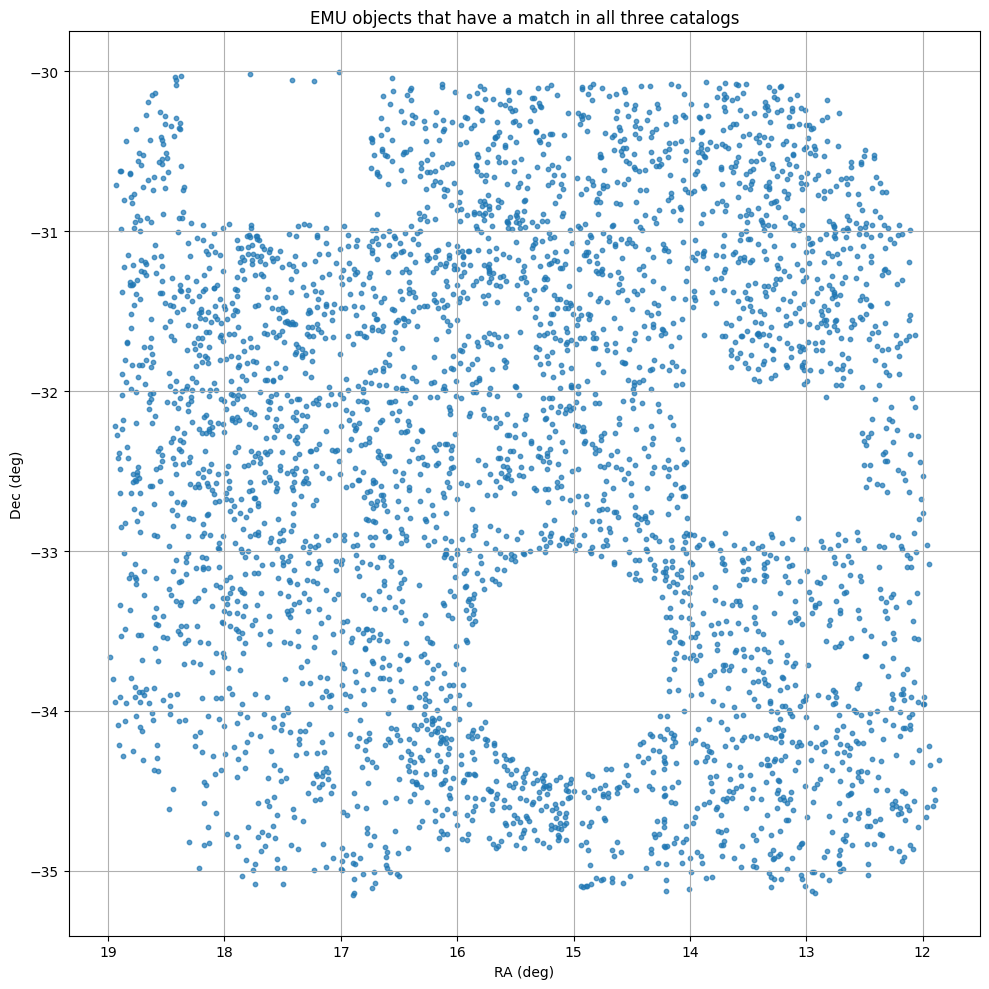

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(catalog_filter['EMU_ra_deg_cont'], catalog_filter['EMU_dec_deg_cont'], s=10, alpha=0.7)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('EMU objects that have a match in all three catalogs')
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: invert RA to match sky convention
plt.tight_layout()
plt.show()

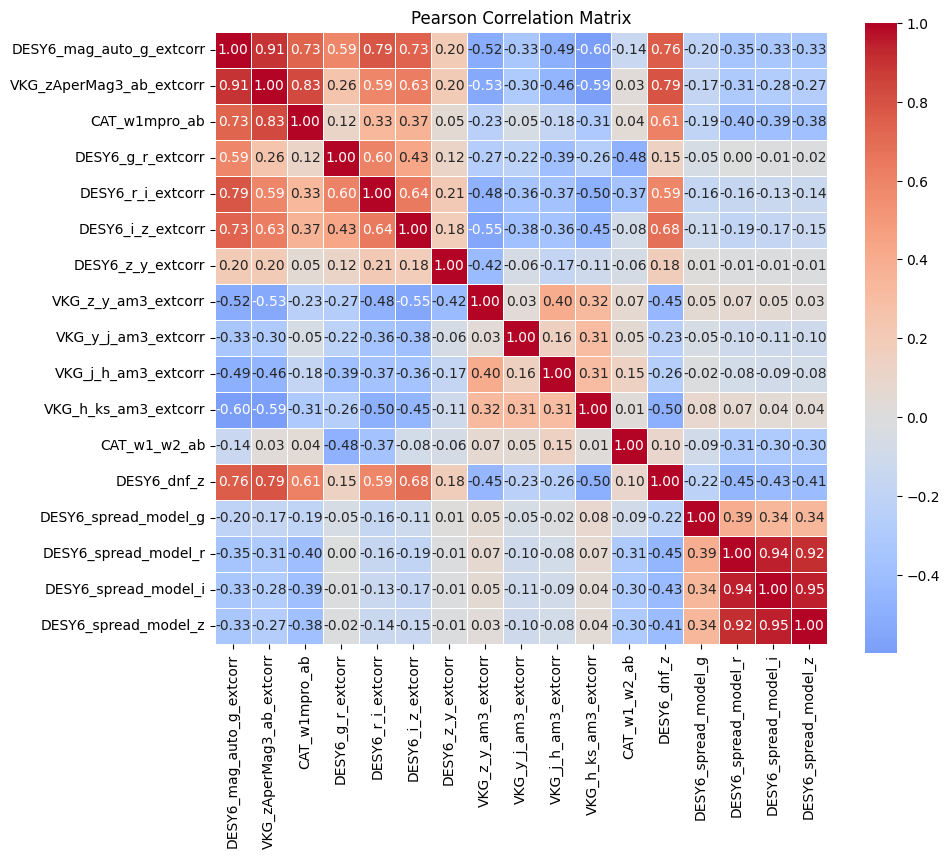

In [12]:
correlation_matrix = catalog_som.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Define the topology of the SOM

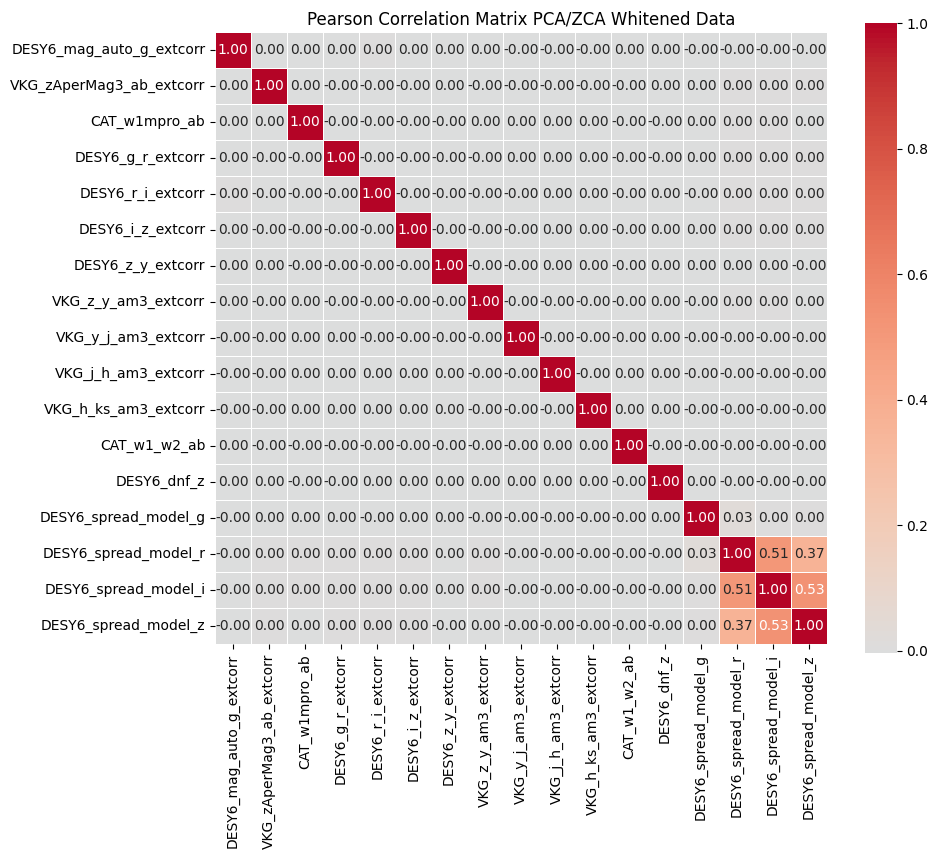

In [13]:
data_fraction2use = 1
data = catalog_som.sample(frac=data_fraction2use)

data.to_numpy()

data_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_original.csv'
data.to_csv(data_path, index=False)

data_white = zca_whitening(data)
data_white.columns = columns[:data_white.shape[1]]

# Save the data white to a new file
data_white_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_zcaWhite.csv'

data_white.to_csv(data_white_path, index=False)


correlation_matrix = data_white.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix PCA/ZCA Whitened Data")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:
# SOM topology (lattice size)

# Number of sources in our dataframe
inputdata_size = len(data_white)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_matrix = np.cov(data_white, rowvar=False)
eigen_values = np.linalg.eigvals(cov_matrix)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes is 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

Dimension of the SOM:  295
Square SOM map size  17.0
Ratio of the two largest eigenvalues:  1
SOM map size using eigenvalues:  17 x 16
Resized SOM map size using eigenvalues:  34 x 33


### Run the SOM

In [15]:
# Define the SOM
som = sps.SOMNet(
    som_x,
    som_y,
    data_white,
    load_file = None,
    metric = 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = False,
    random_seed = 69,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True,
    output_path = '/home/polaris/Lab_Astro/data/soms/maps1/epoch_files'
)

som.train(
    train_algo = 'batch', 
    epochs = 50,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 3 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

2025-05-06 17:31:17.836 | INFO     | simpsom.network:__init__:111 - Periodic Boundary Conditions active.
2025-05-06 17:31:17.837 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-06 17:31:17.838 | INFO     | simpsom.network:_set_weights:196 - The weights will be initialized randomly.
2025-05-06 17:31:17.848 | INFO     | simpsom.network:train:469 - The map will be trained with the batch algorithm.
2025-05-06 17:31:17.850 | DEBUG    | simpsom.network:train:587 - Training SOM... 0.00%
2025-05-06 17:31:18.334 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps1/epoch_files/trained_som_1epoch.npy
2025-05-06 17:31:18.752 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab_Astro/data/soms/maps1/epoch_files/trained_som_2epoch.npy
2025-05-06 17:31:19.148 | INFO     | simpsom.network:save_map:307 - Map shape and weights will be saved to:
/home/polaris/Lab

/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/distances.py:178: RuntimeWarning: invalid value encountered in sqrt
  return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))
2025-05-06 17:31:40.824 | INFO     | simpsom.network:get_nodes_difference:696 - Weights difference among neighboring nodes calculated.
/home/polaris/miniconda3/envs/labastro/lib/python3.10/site-packages/simpsom-3.0.0b0-py3.10.egg/simpsom/plots.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{t:.3f}' for t in ticks])


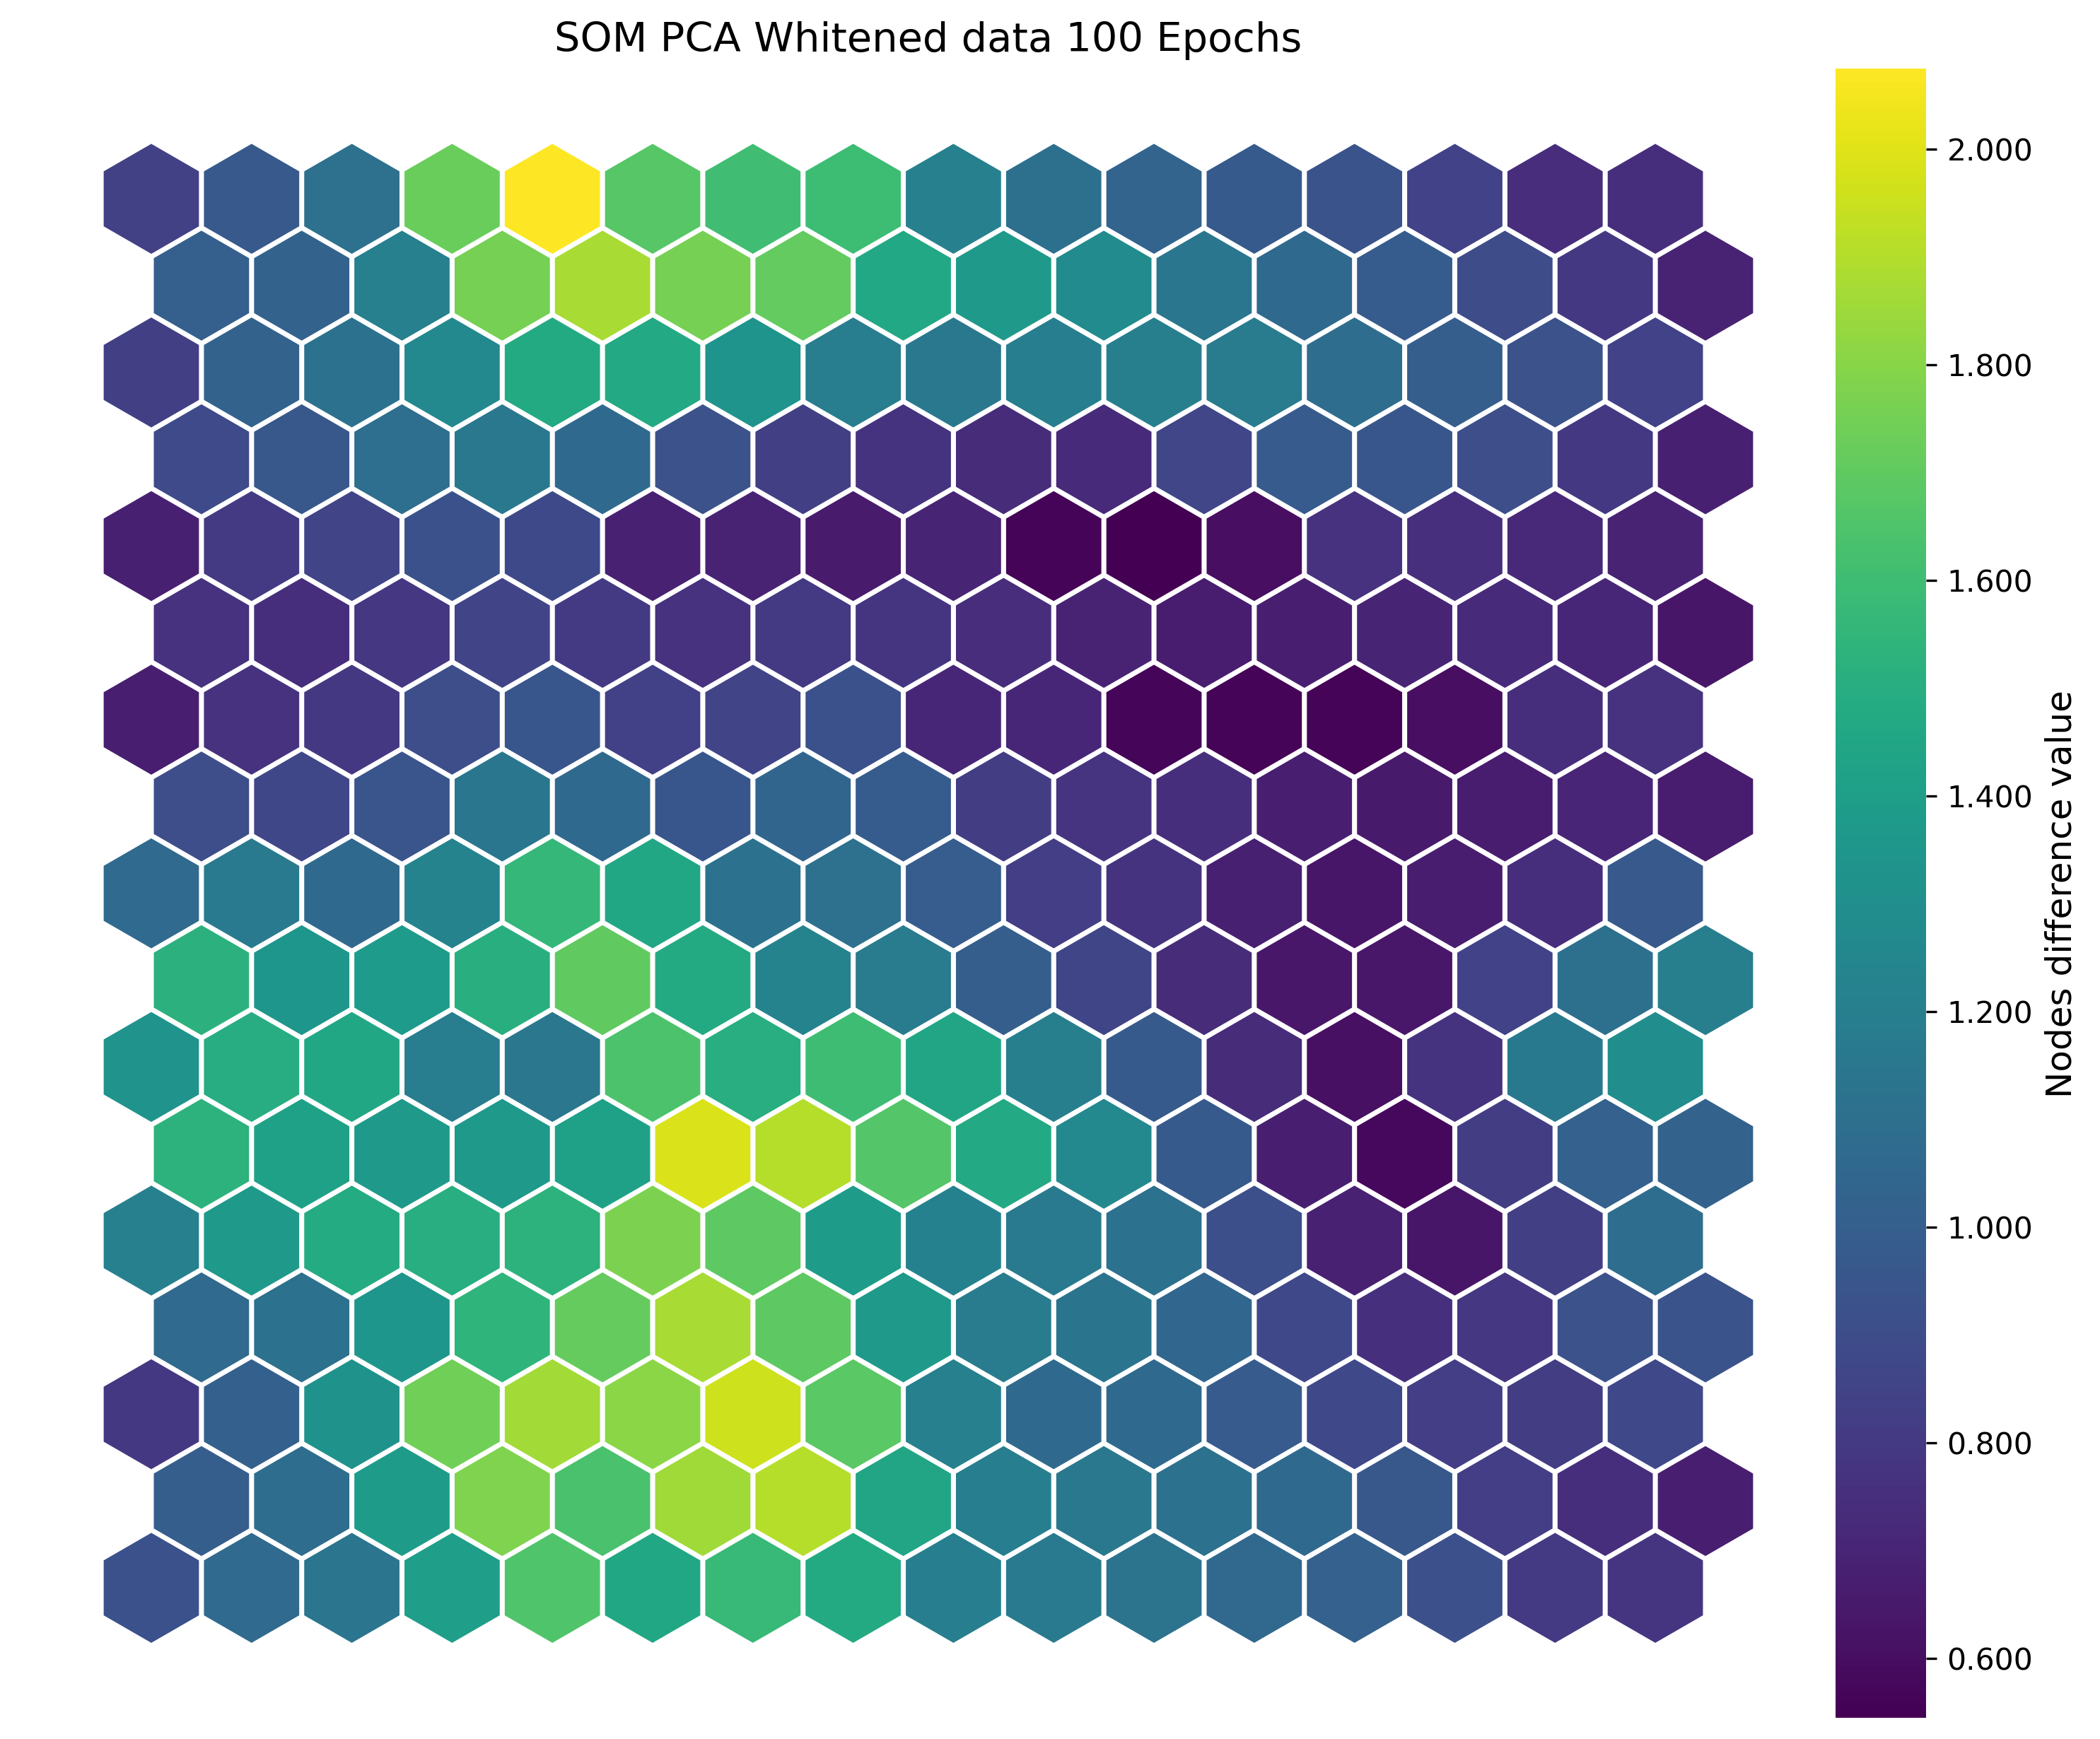

In [16]:
som.plot_map_by_difference(show=True, print_out=False, title='SOM PCA Whitened data 100 Epochs', figsize=(10,10))

## Quantization Error (QE) and Topographic Error (TE)

In [20]:
quantization_error=[]
topographic_error=[]


for i in range(1,50):
    name_file = f'/home/polaris/Lab_Astro/data/soms/maps1/epoch_files/trained_som_' + str(i) + 'epoch'+ '.npy'
    
    # Define the SOM
    sommap = sps.SOMNet(
    17,
    16,
    data_white,
    load_file = name_file,
    )

    # Print the Errors
    quantization_error.append(sommap.calculate_qe())
    topographic_error.append(sommap.calculate_te())

print('Quantization error: ', quantization_error)
print('Topographic error: ', topographic_error)

2025-05-06 17:33:10.676 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-06 17:33:10.681 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.


2025-05-06 17:33:11.990 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-06 17:33:11.991 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-06 17:33:13.327 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-06 17:33:13.331 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-06 17:33:14.503 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-06 17:33:14.504 | INFO     | simpsom.network:_set_weights:201 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-06 17:33:15.936 | INFO     | simpsom.network:__init__:120 - Hexagonal topology.
2025-05-06 17:33:15.937 | INFO     | simpsom.network:_set_weights:201 - The we

Quantization error:  [10.801003456115723, 3.4424760341644287, 3.404374122619629, 3.391935110092163, 3.3794105052948, 3.36612868309021, 3.3536672592163086, 3.341235637664795, 3.329209804534912, 3.31620717048645, 3.3020644187927246, 3.286799192428589, 3.2708215713500977, 3.2543890476226807, 3.2375903129577637, 3.220245122909546, 3.20237398147583, 3.1837856769561768, 3.164351224899292, 3.1439781188964844, 3.1225056648254395, 3.100123882293701, 3.0768370628356934, 3.052677631378174, 3.027700185775757, 3.002060651779175, 2.975950241088867, 2.949312210083008, 2.922489881515503, 2.8953237533569336, 2.86863374710083, 2.8421483039855957, 2.8159267902374268, 2.790276288986206, 2.764824628829956, 2.739774227142334, 2.715292453765869, 2.690267324447632, 2.6651198863983154, 2.639000654220581, 2.6133522987365723, 2.5871071815490723, 2.5613796710968018, 2.535231828689575, 2.5093131065368652, 2.483370065689087, 2.459325075149536, 2.436400890350342, 2.414571523666382]
Topographic error:  [1.0, 0.999713

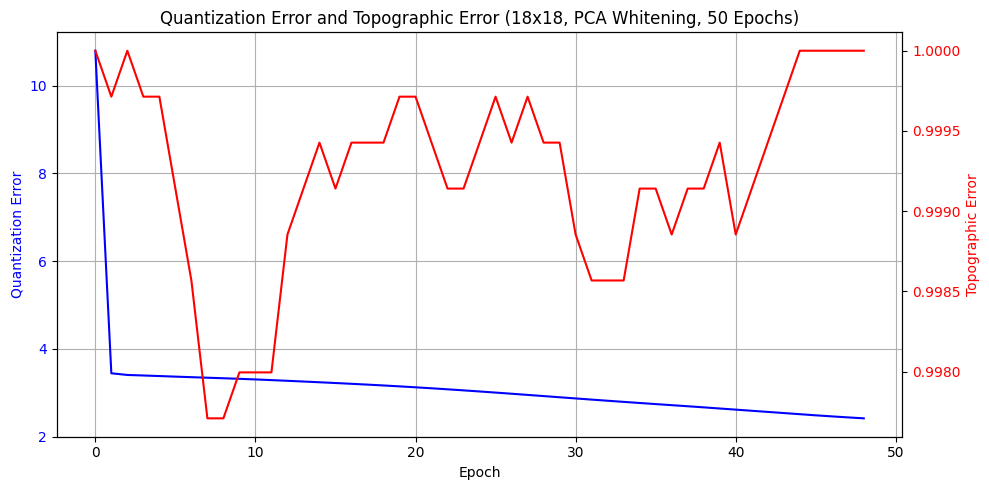

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Quantization Error on the primary y-axis
ax1.plot(quantization_error, label='Quantization Error', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Quantization Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create a secondary y-axis for Topographic Error
ax2 = ax1.twinx()
ax2.plot(topographic_error, label='Topographic Error', color='red')
ax2.set_ylabel('Topographic Error', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Quantization Error and Topographic Error (18x18, PCA Whitening, 50 Epochs)')
fig.tight_layout()
plt.show()

### Plot value of features

This code plots the values of each feature in each node. Remember that this value is after PCA/ZCA, so it needs to be converted back.

In [ ]:
# for i in range(len(columns)):
#     som.plot_map_by_feature(
#         feature_ix= i,
#         show=True,
#         print_out=True,
#         cbar_label=catalog_som.columns[i],
#         figsize = (10,10)
#     )

## Dewhitened prototype features

### Prototype Maps

In [ ]:
all_positions = [[node.pos[0], node.pos[1]] for node in som.nodes_list]
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(columns))] for node in som.nodes_list]

# convert back to the original feature space
weights_dewhitened = inverse_pca_whitening(data, all_weights)

# Plot the dewhitned features
for idx in range(len(columns)):
    weights_dewhitened_feature = [weights_dewhitened[row][idx] for row in range(len(weights_dewhitened))]
    
    hexagon = sps.polygons.Hexagons

    sps.plots.plot_map(
        all_positions,
        weights_dewhitened_feature,
        hexagon,
        title = f'Feature {idx} - {columns[idx]}',
        show = True,
        print_out = True
    )

### Comparison of prototype values with original values

In [ ]:
num_cols = 6
num_rows = 3        
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, col in enumerate(columns):
    if i < len(axes):
        ax = axes[i]
        original_data = catalog_som[col]
        som_column_data = [weights_dewhitened[row][columns.index(col)] for row in range(len(weights_dewhitened))]

        # Histogram of the original data
        ax.hist(original_data, weights=np.ones(len(original_data)) / len(catalog_som), bins=100, alpha=0.6, label='Original Data', color='skyblue')

        # Histogram of the dewhitened prototypes
        ax.hist(som_column_data, weights=np.ones(len(som_column_data)) / len(weights_dewhitened), bins=100, alpha=0.6, label='SOM Prototypes', color='red')

        # Kolmogorov-Smirnov test: how similar are the distributions?
        ks_statistic, p_value = kstest(original_data, som_column_data)
        ax.set_title(f'{col}\nKS Statistic: {ks_statistic:.2f}, p-value: {p_value:.3f}', fontsize=8)


        ax.set_xlabel('Values', fontsize=7)
        ax.set_ylabel('Probability Density', fontsize=7)
        ax.legend(fontsize=6)
        ax.grid(True, alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=5)

# Remove any unused subplots
if len(columns) < len(axes):
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Access, Convert, Save and Plot the Galaxy Prototypes

In [ ]:
# Create a dataframe with the weights for easier access
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(columns))] for node in som.nodes_list]


prototypes_df = pd.DataFrame()

# Convert the colors to magnitudes and save the magnitudes
for idx in range(len(columns)):
    prototypes_df['id'] = idx
    prototypes_df['redshift'] = 